In [2]:
from xgboost import XGBRegressor

import sys
if '..' not in sys.path:
    sys.path.append('..')

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import cv2
import tqdm
import gzip
import multiprocessing.pool

import utils

In [3]:
FEAT_ROOT = '../runs/unet-limit500/'
# FEAT_ROOT = '../runs/unet-limit100-nolw0.1-lr0.0002/'

In [4]:
def load_pred(path):
    with gzip.open(str(path), 'rb') as f:
        return np.load(f).astype(np.float32) / 1000

In [5]:
IMG_ID = 200
img = utils.load_image(Path('../data/Train/{}.jpg'.format(IMG_ID)), cache=False)
pred = load_pred('{}/{}-pred.npy'.format(FEAT_ROOT, IMG_ID))
img.shape, pred.shape

((3328, 4992, 3), (6, 3328, 4992))

In [ ]:
plt.figure(figsize=(12, 10))
plt.imshow(img);

In [ ]:
size = (1000, 600)
small_img = cv2.resize(img, size)
pred_sum = pred[:utils.N_CLASSES].sum(axis=0)

#"""
for cls in range(utils.N_CLASSES):
    plt.figure(figsize=(16, 12))
    plt.imshow(small_img)
    plt.imshow(cv2.resize(pred[cls], size), alpha=0.5)
    plt.show()
#"""

plt.figure(figsize=(16, 12))
plt.imshow(small_img)
plt.imshow(cv2.resize(pred_sum, size), alpha=0.7)
plt.show()

In [6]:
all_coords = utils.load_coords()

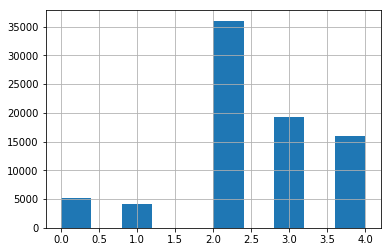

In [7]:
all_coords.cls.hist()

In [75]:
def load_xs_ys(pred_path):
    pred = load_pred(pred_path)
    img_id = int(pred_path.name.split('-')[0])
    xs, ys = [], []
    for cls in range(utils.N_CLASSES):
        try:
            ys.append(
                (all_coords.loc[img_id].cls == cls).sum())
        except KeyError:
            ys.append(0)
        cls_pred = pred[cls]
        thresholds = [0.02, 0.25]
        x = [cls_pred.sum()]
        for i, threshold in enumerate(thresholds):
            bin_mask = cls_pred > threshold
            if i + 1 < len(thresholds):
                bin_mask &= cls_pred < thresholds[i + 1]
            x.append(bin_mask.sum())
        xs.append(x)
    return xs, ys

all_xs = [[] for _ in range(utils.N_CLASSES)]
all_ys = [[] for _ in range(utils.N_CLASSES)]
valid_ids = {int(p.stem) for p in utils.labeled_paths()}
with multiprocessing.pool.ThreadPool(processes=6) as pool:
    img_paths = [p for p in Path(FEAT_ROOT).glob('*-pred.npy')
                 if int(p.name.split('-')[0]) in valid_ids]
    print('{} total'.format(len(img_paths)))
    for i, (xs, ys) in enumerate(pool.imap_unordered(load_xs_ys, img_paths, chunksize=2)):
        if i % 50 == 0:
            print(i)
        for cls in range(utils.N_CLASSES):
            all_xs[cls].append(xs[cls])
            all_ys[cls].append(ys[cls])
all_xs = np.array(all_xs)
all_ys = np.array(all_ys)

517 total
0
50
100
150
200
250
300
350
400
450
500


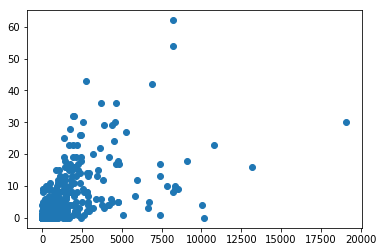

In [49]:
plt.scatter(all_xs[0][:, 0], all_ys[0])

In [80]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from IPython.core.display import display
from eli5 import show_weights
from sklearn.dummy import DummyRegressor

def evaluate(*regs, explain=False):
    print()
    all_rmse = []
    regs_name = ', '.join(type(reg).__name__ for reg in regs)
    for cls in range(utils.N_CLASSES):
        xs, ys = all_xs[cls], all_ys[cls]
        preds = [cross_val_predict(reg, xs, ys, cv=5) for reg in regs]
        pred = np.mean(preds, axis=0)
        rmse = np.sqrt(metrics.mean_squared_error(ys, pred))
        print('cls {}, target mean {:.2f}, RMSE {:.2f}'.format(cls, np.mean(ys), rmse))
        all_rmse.append(np.mean(rmse))
        if explain:
            reg.fit(xs, ys)
            display(show_weights(reg, target_names=['cls-{}'.format(cls)]))
    print('Average RMSE for {}: {:.2f}'.format(regs_name, np.mean(all_rmse)))

evaluate(DummyRegressor())
  
evaluate(Lasso(alpha=1.0, normalize=False, max_iter=1000000))


cls 0, target mean 5.47, RMSE 7.43
cls 1, target mean 4.47, RMSE 6.36
cls 2, target mean 38.17, RMSE 71.30
cls 3, target mean 22.18, RMSE 48.39
cls 4, target mean 16.87, RMSE 50.62
Average RMSE for DummyRegressor: 36.82

cls 0, target mean 5.47, RMSE 6.20
cls 1, target mean 4.47, RMSE 6.16
cls 2, target mean 38.17, RMSE 40.12
cls 3, target mean 22.18, RMSE 36.34
cls 4, target mean 16.87, RMSE 29.59
Average RMSE for Lasso: 23.68


In [83]:
evaluate(Lasso(alpha=1.0, normalize=False, max_iter=100000),
         XGBRegressor(n_estimators=10, max_depth=2))


cls 0, target mean 5.47, RMSE 6.17
cls 1, target mean 4.47, RMSE 6.09
cls 2, target mean 38.17, RMSE 42.52
cls 3, target mean 22.18, RMSE 34.76
cls 4, target mean 16.87, RMSE 32.24
Average RMSE for Lasso, XGBRegressor: 24.35


In [81]:
evaluate(XGBRegressor(n_estimators=10, max_depth=2))


cls 0, target mean 5.47, RMSE 6.56
cls 1, target mean 4.47, RMSE 6.24
cls 2, target mean 38.17, RMSE 50.23
cls 3, target mean 22.18, RMSE 36.40
cls 4, target mean 16.87, RMSE 38.26
Average RMSE for XGBRegressor: 27.54


In [82]:
evaluate(XGBRegressor(n_estimators=50, max_depth=2),
         Lasso(alpha=1.0, normalize=False, max_iter=100000))


cls 0, target mean 5.47, RMSE 6.07
cls 1, target mean 4.47, RMSE 6.08
cls 2, target mean 38.17, RMSE 38.29
cls 3, target mean 22.18, RMSE 32.60
cls 4, target mean 16.87, RMSE 30.36
Average RMSE for XGBRegressor, Lasso: 22.68


In [88]:
from sklearn.externals import joblib
from sklearn.base import clone

def evaluate_stacked(*regs, save_to=None):
    print()
    stacked_xs = np.concatenate(all_xs, axis=1)
    all_rmse = []
    regs_name = ', '.join(type(reg).__name__ for reg in regs)
    fitted_regs = []
    for cls in range(utils.N_CLASSES):
        ys = all_ys[cls]
        xs = stacked_xs
        preds = [cross_val_predict(reg, xs, ys, cv=5) for reg in regs]
        pred = np.mean(preds, axis=0)
        rmse = np.sqrt(metrics.mean_squared_error(ys, pred))
        print('cls {}, target mean {:.2f}, RMSE {:.2f}'.format(cls, np.mean(ys), rmse))
        all_rmse.append(np.mean(rmse))
        if save_to:
            fitted = []
            for reg in regs:
                reg = clone(reg)
                reg.fit(xs, ys)
                fitted.append(reg)
            fitted_regs.append(fitted)
    print('Average RMSE for {}: {:.2f}'.format(regs_name, np.mean(all_rmse)))
    if save_to:
        joblib.dump(fitted_regs, save_to)
        print('Saved to', save_to)

evaluate_stacked(Lasso(alpha=1.0, normalize=False, max_iter=100000),
                save_to=FEAT_ROOT + 'lasso.joblib')


cls 0, target mean 5.47, RMSE 4.85
cls 1, target mean 4.47, RMSE 6.05
cls 2, target mean 38.17, RMSE 39.81
cls 3, target mean 22.18, RMSE 37.44
cls 4, target mean 16.87, RMSE 25.56
Average RMSE for Lasso: 22.74
Saved to ../runs/unet-limit500/lasso.joblib


In [85]:
def check(path):
    all_regs = joblib.load(path)
    stacked_xs = np.concatenate(all_xs, axis=1)
    all_rmse = []
    for cls, cls_regs in enumerate(all_regs):
        ys = all_ys[cls]
        xs = stacked_xs
        preds = [reg.predict(xs) for reg in cls_regs]
        pred = np.mean(preds, axis=0)
        rmse = np.sqrt(metrics.mean_squared_error(ys, pred))
        print('cls {}, target mean {:.2f}, RMSE {:.2f}'.format(cls, np.mean(ys), rmse))
        all_rmse.append(np.mean(rmse))
    print('Average RMSE for {}: {:.2f}'.format(path, np.mean(all_rmse)))

check(FEAT_ROOT + 'lasso.joblib')

cls 0, target mean 5.47, RMSE 4.41
cls 1, target mean 4.47, RMSE 5.55
cls 2, target mean 38.17, RMSE 33.57
cls 3, target mean 22.18, RMSE 31.56
cls 4, target mean 16.87, RMSE 22.38
Average RMSE for ../runs/unet-limit500/lasso.joblib: 19.49


In [92]:
evaluate_stacked(XGBRegressor(n_estimators=10, max_depth=2))

cls 0, target mean 5.27, RMSE 5.72 +- 1.72
cls 1, target mean 4.29, RMSE 6.04 +- 1.98
cls 2, target mean 37.08, RMSE 50.16 +- 12.26
cls 3, target mean 21.16, RMSE 35.43 +- 11.22
cls 4, target mean 16.30, RMSE 35.72 +- 10.01
Average RMSE for <class 'xgboost.sklearn.XGBRegressor'>: 26.61


In [93]:
evaluate_stacked(XGBRegressor(n_estimators=100, max_depth=2))

cls 0, target mean 5.27, RMSE 4.27 +- 1.24
cls 1, target mean 4.29, RMSE 5.88 +- 1.49
cls 2, target mean 37.08, RMSE 38.63 +- 10.13
cls 3, target mean 21.16, RMSE 33.50 +- 12.84
cls 4, target mean 16.30, RMSE 26.85 +- 9.80
Average RMSE for <class 'xgboost.sklearn.XGBRegressor'>: 21.83


In [98]:
evaluate_stacked(XGBRegressor(n_estimators=50, max_depth=2))

cls 0, target mean 5.27, RMSE 4.35 +- 1.23
cls 1, target mean 4.29, RMSE 5.87 +- 1.57
cls 2, target mean 37.08, RMSE 39.00 +- 10.58
cls 3, target mean 21.16, RMSE 33.41 +- 11.46
cls 4, target mean 16.30, RMSE 26.50 +- 11.92
Average RMSE for <class 'xgboost.sklearn.XGBRegressor'>: 21.82


In [99]:
evaluate_stacked(XGBRegressor(n_estimators=300, learning_rate=0.03))

cls 0, target mean 5.27, RMSE 4.35 +- 1.32
cls 1, target mean 4.29, RMSE 5.78 +- 1.46
cls 2, target mean 37.08, RMSE 38.48 +- 10.60
cls 3, target mean 21.16, RMSE 34.87 +- 11.95
cls 4, target mean 16.30, RMSE 27.36 +- 9.64
Average RMSE for <class 'xgboost.sklearn.XGBRegressor'>: 22.17


In [22]:
evaluate_stacked(XGBRegressor(n_estimators=50, max_depth=2),
                 Lasso(alpha=1.0, normalize=False, max_iter=100000))

cls 0, target mean 5.27, RMSE 4.55
cls 1, target mean 4.29, RMSE 5.74
cls 2, target mean 37.08, RMSE 38.20
cls 3, target mean 21.16, RMSE 32.75
cls 4, target mean 16.30, RMSE 25.51
Average RMSE for XGBRegressor, Lasso: 21.35


In [86]:
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor

evaluate_stacked(ExtraTreesRegressor(n_estimators=50))
evaluate_stacked(BaggingRegressor(n_estimators=50))
evaluate_stacked(ExtraTreesRegressor(n_estimators=50),
                 BaggingRegressor(n_estimators=50))

cls 0, target mean 5.47, RMSE 4.44
cls 1, target mean 4.47, RMSE 5.99
cls 2, target mean 38.17, RMSE 36.76
cls 3, target mean 22.18, RMSE 31.48
cls 4, target mean 16.87, RMSE 26.21
Average RMSE for ExtraTreesRegressor: 20.98
cls 0, target mean 5.47, RMSE 4.36
cls 1, target mean 4.47, RMSE 5.96
cls 2, target mean 38.17, RMSE 38.93
cls 3, target mean 22.18, RMSE 33.73
cls 4, target mean 16.87, RMSE 26.21
Average RMSE for BaggingRegressor: 21.84
cls 0, target mean 5.47, RMSE 4.36
cls 1, target mean 4.47, RMSE 5.94
cls 2, target mean 38.17, RMSE 38.24
cls 3, target mean 22.18, RMSE 31.02
cls 4, target mean 16.87, RMSE 25.94
Average RMSE for ExtraTreesRegressor, BaggingRegressor: 21.10


In [87]:
evaluate_stacked(ExtraTreesRegressor(n_estimators=50),
                 Lasso(alpha=1.0, normalize=False, max_iter=100000))

cls 0, target mean 5.47, RMSE 4.49
cls 1, target mean 4.47, RMSE 5.82
cls 2, target mean 38.17, RMSE 35.98
cls 3, target mean 22.18, RMSE 31.82
cls 4, target mean 16.87, RMSE 24.48
Average RMSE for ExtraTreesRegressor, Lasso: 20.52


In [89]:
evaluate_stacked(
    ExtraTreesRegressor(n_estimators=50),
    BaggingRegressor(n_estimators=50),
    XGBRegressor(n_estimators=50, max_depth=2),
    Lasso(alpha=1.0, normalize=False, max_iter=100000),
)


cls 0, target mean 5.47, RMSE 4.40
cls 1, target mean 4.47, RMSE 5.82
cls 2, target mean 38.17, RMSE 37.17
cls 3, target mean 22.18, RMSE 30.56
cls 4, target mean 16.87, RMSE 25.29
Average RMSE for ExtraTreesRegressor, BaggingRegressor, XGBRegressor, Lasso: 20.65


In [90]:
evaluate_stacked(
    ExtraTreesRegressor(n_estimators=50),
    # BaggingRegressor(n_estimators=50),
    XGBRegressor(n_estimators=50, max_depth=2),
    Lasso(alpha=1.0, normalize=False, max_iter=100000),
)


cls 0, target mean 5.47, RMSE 4.39
cls 1, target mean 4.47, RMSE 5.81
cls 2, target mean 38.17, RMSE 36.78
cls 3, target mean 22.18, RMSE 30.26
cls 4, target mean 16.87, RMSE 24.88
Average RMSE for ExtraTreesRegressor, XGBRegressor, Lasso: 20.42
